In [64]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

import lsst.sims.maf.db as db
import lsst.sims.maf.stackers as stackers
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.metricBundles as mb
import lsst.sims.maf.batches as batches

In [2]:
runName = 'baseline-2018a'
opsdb = db.OpsimDatabase('/Users/lynnej/opsim/db/astro-lsst-01_2022.db')
colmap = batches.ColMapDict('opsimv4')

In [3]:
proptags, propinfo = opsdb.fetchPropInfo()
wfdWhere = opsdb.createSQLWhere('WFD', propinfo)
wfdWhere

'proposalId = 3'

0.690329343146 359.08888492 -59.4332875756 1.73531718565


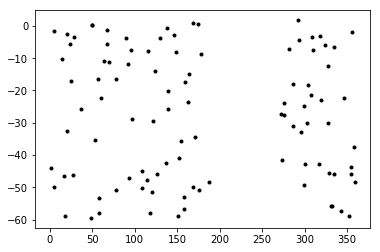

In [4]:
# Choose 100 random ra/dec values within the WFD fields
# RA range excludes galactic plane (roughly, exclude ra between 190 - 270 to avoid all areas near GP)
ra = (np.random.rand(100) * (360 - (270-190)) + 270) % 360
# Dec range is about -62 to +2
dec = np.random.rand(100) * (62) - 60
print(ra.min(), ra.max(), dec.min(), dec.max())
plt.plot(ra, dec, 'k.')

In [5]:
dither = stackers.RandomDitherPerNightStacker()
raCol, decCol, degrees, stacker, ditherMeta = batches.radecCols(dither, colmap)
s = slicers.UserPointsSlicer(ra=ra, dec=dec, latCol=decCol, lonCol=raCol, latLonDeg=colmap['raDecDeg'])
m = metrics.PassMetric(cols=[raCol, decCol, colmap['mjd'], 
                             colmap['filter'], colmap['fiveSigmaDepth'], colmap['seeingGeom']])
bundle = mb.MetricBundle(m, s, constraint=wfdWhere, stackerList=dither, runName=runName, metadata='WFD')
m2 = metrics.CountMetric(colmap['mjd'], metricName='Nvisits')
bundle2 = mb.MetricBundle(m2, s, constraint=wfdWhere, stackerList=dither, runName=runName, metadata='WFD')

In [6]:
g = mb.MetricBundleGroup({'pass':bundle, 'count': bundle2}, opsdb, 'test', None)
g.runAll()

Querying database SummaryAllProps with constraint proposalId = 3 for columns ['night', 'seeingFwhmGeom', 'fieldDec', 'fiveSigmaDepth', 'observationStartMJD', 'filter', 'fieldRA']
Found 2049326 visits
Running:  ['pass', 'count']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


In [7]:
# How many points had observations? (maybe I missed some ra/dec locations)
print(len(bundle.metricValues.compressed()))

96


In [9]:
plotDict = {'figsize': (8, 5)}
bundle2.setPlotDict(plotDict)

{'SkyMap': 1, 'Histogram': 2}

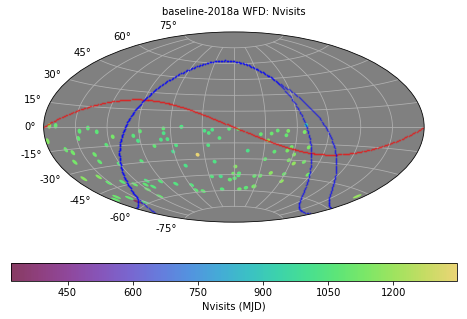

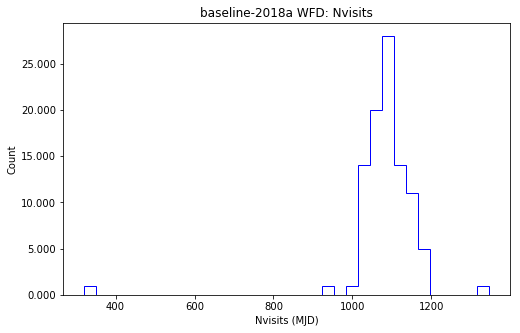

In [10]:
bundle2.plot()

In [30]:
bins = np.arange(0, 365, 1)
npts = len(bundle.metricValues.compressed())
h = np.zeros((npts, len(bins)-1))
for i, p in enumerate(bundle.metricValues.compressed()):
    mjds = np.unique(p['night'])
    h[i], b = np.histogram(np.diff(mjds), bins)

(1.6375915750915755, 265.97916666666669)

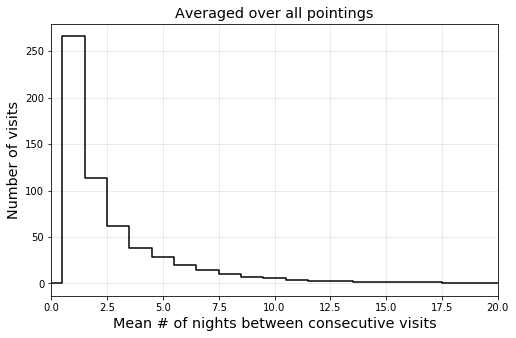

In [42]:
plt.figure(figsize=(8, 5))
h2 = np.mean(h, axis=0)
width = np.diff(bins)
leftedge = bins[:-1] - width/2.0
rightedge = bins[:-1] + width/2.0
x = np.ravel(list(zip(leftedge, rightedge)))
y = np.ravel(list(zip(h2, h2)))
plt.plot(x, y, 'k-')
plt.xlim(0, 20)
plt.xlabel("Mean # of nights between consecutive visits", fontsize='x-large')
plt.ylabel("Number of visits", fontsize='x-large')
plt.title("Averaged over all pointings", fontsize='x-large')
plt.grid(True, alpha=0.3)
h2.mean(), h2.max()

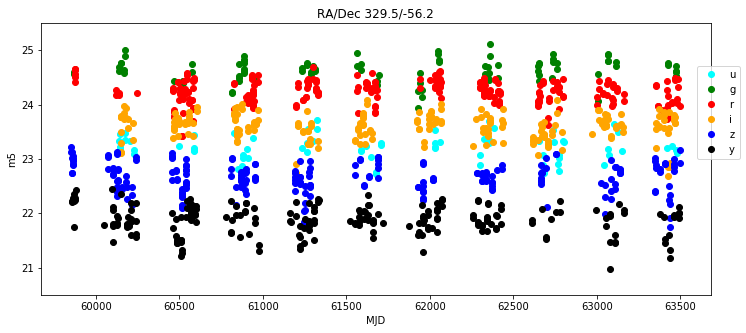

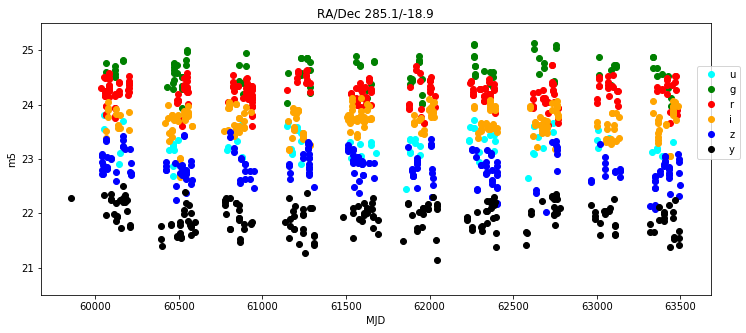

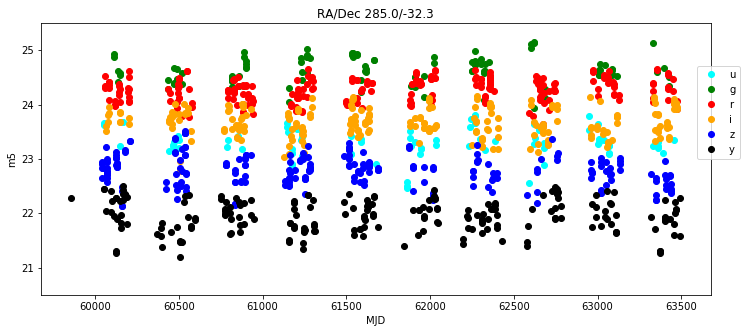

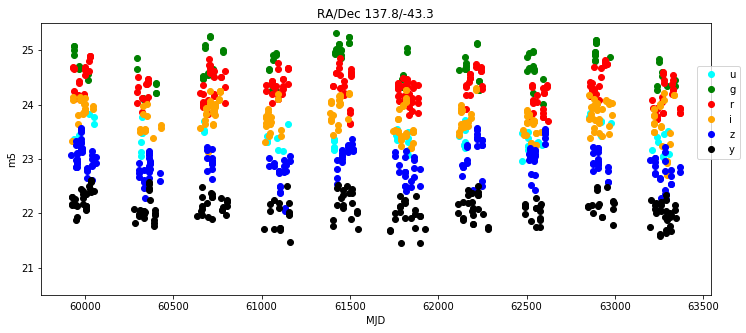

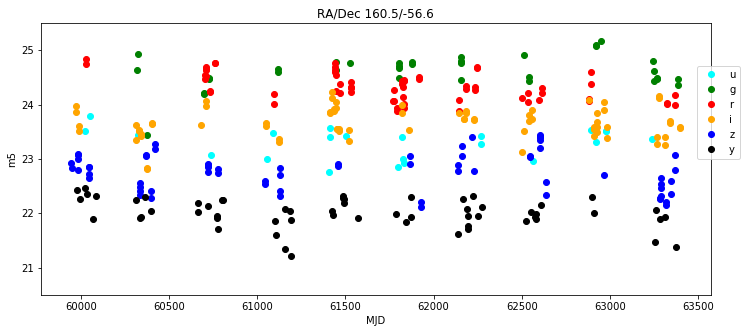

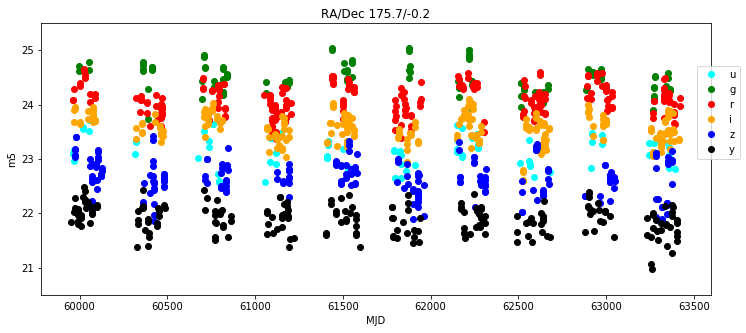

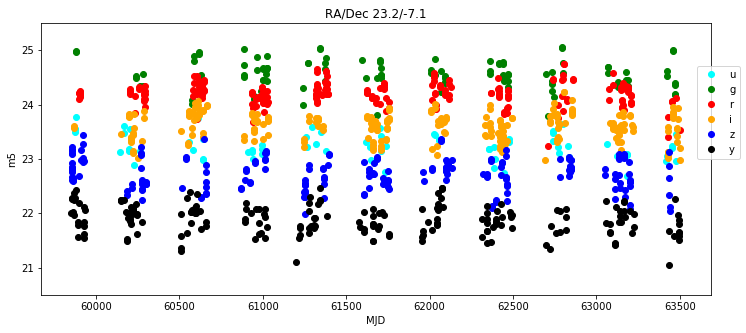

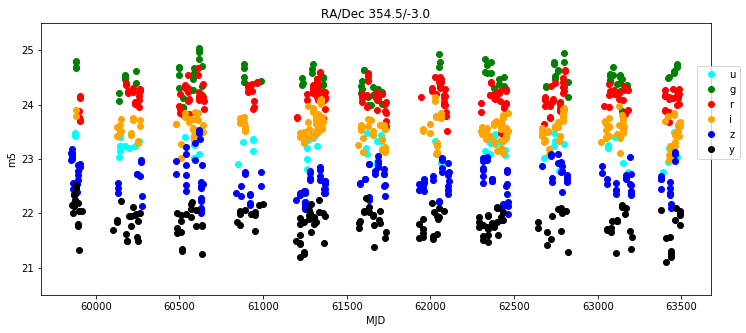

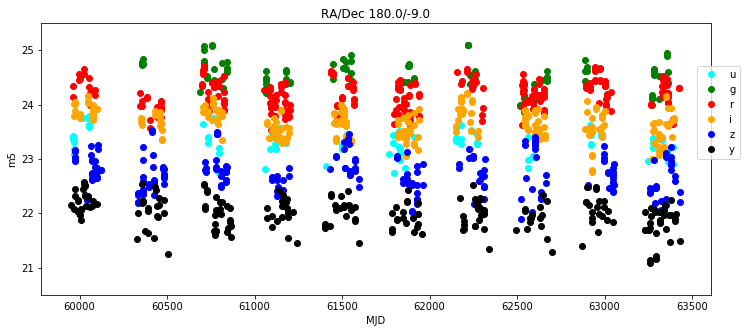

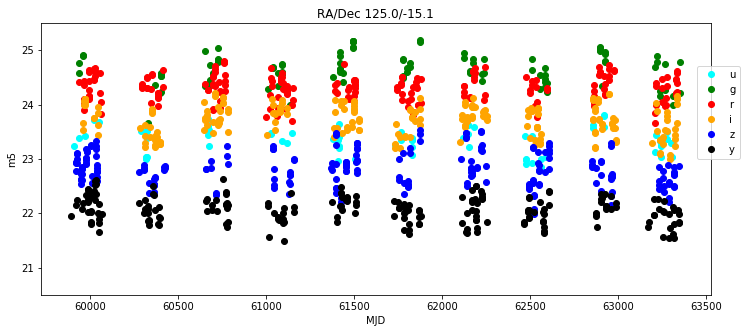

In [63]:
colors = {'u': 'cyan', 'g': 'g', 'r': 'r', 'i': 'orange', 'z': 'blue', 'y': 'k'}
for p in bundle.metricValues.compressed()[0:10]:
    plt.figure(figsize=(12, 5))
    for f in ('u', 'g', 'r', 'i', 'z', 'y'):
        matched = np.where(p['filter'] == f)
        plt.plot(p['observationStartMJD'][matched], p['fiveSigmaDepth'][matched], 
                 color=colors[f], linestyle='', marker='o', label=f)
        plt.xlabel("MJD")
        plt.ylabel("m5")
        plt.title("RA/Dec %.1f/%.1f" % (p[raCol][0], p[decCol][0]))
        plt.ylim(20.5, 25.5)
        plt.legend(loc=(0.98, .5), fancybox=True, numpoints=1)

In [67]:
# Write the individual results into csv files
for p in bundle.metricValues.compressed():
    filename = 'baseline-201a-RA_%.1f_Dec_%.1f' % (p[raCol][0], p[decCol][0])
    df = pd.DataFrame(p)
    df.to_csv('test/' + filename, index=False)